In [1]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
nh = uri.RamsesSnapshot(repo, iout, mode=rurmode)
nhs = uri.TimeSeries(nh)
nhs.read_iout_avail()
nout = nhs.iout_avail['iout']
gals = uhmi.HaloMaker.load(nh, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(nh, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"
LG = pklload(f"{database}/LG")
keys = []
for key in LG.keys():
    if(LG[key]['isLG']): keys.append(key)
keys = np.array(keys)
print(keys)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


[  1   3   7   8  10  23  25  26  36  64 121 129  11]


In [3]:
tree = pklload(f"{database}/02_main_progenitors.pickle")

In [4]:
rtree = pklload(f"{database}/06_reduced_tree.pickle")

New Algorithm with "stable" particles?

In [6]:
nh.get_part(pname='dm', target_fields=['id'], nthread=32)
maxid = len(nh.part['id'])
nh.part.shape

Reading 4800 part files (35.98 GiB) in /storage6/NewHorizon/snapshots/output_01026... 
Allocating Memory...


Done (2.821 sec)


Reading parts:   0%|          | 0/4800 [00:00<?, ?it/s]

Done (9.446s).


(126492136,)

In [7]:
iouts = os.listdir("/storage6/NewHorizon/halo")
iouts = [int(f[-5:]) for f in iouts if f.startswith("tree_bricks")]
iouts.sort()
iouts = np.array(iouts[::-1])

ttable = nhs.iout_avail
mask = ttable['age'] >= (nh.age-0.25)
ttable[mask]['iout']

iouts = iouts[iouts >= np.min(ttable[mask]['iout'])]
iouts.shape, iouts

((35,),
 array([1026, 1025, 1024, 1023, 1022, 1021, 1020, 1019, 1018, 1017, 1016,
        1015, 1014, 1013, 1012, 1011, 1010, 1009, 1008, 1007, 1006, 1005,
        1004, 1003, 1002, 1001, 1000,  999,  998,  997,  996,  995,  994,
         993,  992]))

### Example 1

In [45]:
tid = 20176
final = hals[tid-1]
final

(614, 20176, 1026, 2, 573, 573, 0, 20177, 0.85361391, 8.01399144e+08, 0.50041411, 0.49722965, 0.49063914, -208.34693026, -36.40497756, -124.92434242, -34732852.25019152, -83607812.28576629, 65705527.59170663, 9.95262422e-05, 0.00219804, 0.00331537, 0.00266059, 317.81196215, -3.2585066, 314.55345555, 8.02326491, 150.30961747, 9.95262422e-05, 8.01399144e+08, 10253.83546464, 16.90035933, 362.87718266, 9.95262422e-05, 0.)

In [46]:
pid = uhmi.HaloMaker.read_member_part(nh, tid, galaxy=False, simple=True)

base = np.zeros(maxid, dtype=np.float64)
base[pid-1] += 1

uri.timer.verbose=0
NOUT = 1
for pout in tqdm(iouts[1:]):
    psnap = nhs.get_snap(pout)
    if(psnap.age < (nh.age-1)): break
    phals, ppids = uhmi.HaloMaker.load(psnap, galaxy=False, load_parts=True)
    cparts = phals['nparts']; cparts = np.cumsum(cparts); cparts = np.insert(cparts, 0, 0)
    progids = np.zeros(max(maxid, ppids.max()), dtype=np.int32)
    cursor=0
    for i in range(len(phals)):
        phal = phals[i]
        myid = ppids[cursor:cursor+phal['nparts']]
        progids[myid-1] = phal['id']
        cursor += phal['nparts']

    progs = progids[pid-1]
    if(0 in progs): progs = progs[progs>0]
    unique, counts = np.unique(progs, return_counts=True)
    argsort = np.argsort(-counts)
    unique, counts = unique[argsort], counts[argsort]
    for uni, cou in zip(unique, counts):
        phal = phals[uni-1]
        tmp = ppids[cparts[uni-1] : cparts[uni]]
        base[tmp-1] += cou/phal['nparts']
        # print(f"[{pout}] Halo{uni} -> ({cou}){len(tmp)} parts get score-{cou/phal['nparts']:.6f}")
    # pid = np.where(base>0)[0]+1
    NOUT += 1

  0%|          | 0/34 [00:00<?, ?it/s]

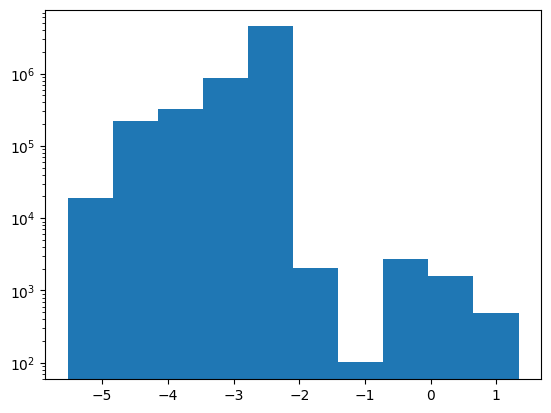

In [47]:
plt.hist(np.log10(base[base>0]))
plt.yscale('log')

In [48]:
# What should be threshold?
print(np.max(base))
cut = np.median(base[base>0]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.median(base[base>1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.median(base[base > (NOUT/10)]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.median(base[pid-1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[base>0]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[base>1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[pid-1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[base > (NOUT/10)]); print(f"{cut:5f} -> {np.sum(base>cut)}" )

21.74196039981098


0.002081 -> 13988
1.323623 -> 1012
15.715986 -> 253
12.983762 -> 317
0.003630 -> 9131
4.754546 -> 479
11.842617 -> 343
14.746288 -> 278


### Example 2

In [49]:
tid = 27322
final = hals[tid-1]
final

(220, 27322, 1026, 2, 10872, 10872, 0, 27323, 0.85361391, 3.96783941e+08, 0.54004821, 0.50139471, 0.51149277, -81.54584342, 201.209394, 71.33802077, 3202667.81286522, 56301871.84044226, 1.53678514e+08, 0.00018238, 0.00568587, 0.00311971, 0.00225822, 228.76046231, -0.62067514, 228.13978717, 57.9683464, 208.00135848, 0.00011682, 3.96783941e+08, 4325.29743001, 10.97642098, 111.10615913, 0.00011682, 1.14858509e+08)

In [50]:
pid = uhmi.HaloMaker.read_member_part(nh, tid, galaxy=False, simple=True)

base = np.zeros(maxid, dtype=np.float64)
base[pid-1] += 1

uri.timer.verbose=0
NOUT = 1
for pout in tqdm(iouts[1:]):
    psnap = nhs.get_snap(pout)
    if(psnap.age < (nh.age-1)): break
    phals, ppids = uhmi.HaloMaker.load(psnap, galaxy=False, load_parts=True)
    cparts = phals['nparts']; cparts = np.cumsum(cparts); cparts = np.insert(cparts, 0, 0)
    progids = np.zeros(max(maxid, ppids.max()), dtype=np.int32)
    cursor=0
    for i in range(len(phals)):
        phal = phals[i]
        myid = ppids[cursor:cursor+phal['nparts']]
        progids[myid-1] = phal['id']
        cursor += phal['nparts']

    progs = progids[pid-1]
    if(0 in progs): progs = progs[progs>0]
    unique, counts = np.unique(progs, return_counts=True)
    argsort = np.argsort(-counts)
    unique, counts = unique[argsort], counts[argsort]
    for uni, cou in zip(unique, counts):
        phal = phals[uni-1]
        tmp = ppids[cparts[uni-1] : cparts[uni]]
        base[tmp-1] += cou/phal['nparts']
        # print(f"[{pout}] Halo{uni} -> ({cou}){len(tmp)} parts get score-{cou/phal['nparts']:.6f}")
    # pid = np.where(base>0)[0]+1
    NOUT += 1

  0%|          | 0/34 [00:00<?, ?it/s]

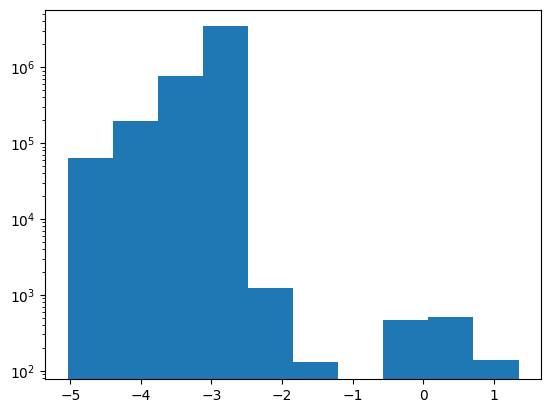

In [51]:
plt.hist(np.log10(base[base>0]))
plt.yscale('log')

In [54]:
len(pid)

220

In [52]:
# What should be threshold?
print(np.max(base))
cut = np.median(base[base>0]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.median(base[base>1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.median(base[base > (NOUT/10)]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.median(base[pid-1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[base>0]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[base>1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[pid-1]); print(f"{cut:5f} -> {np.sum(base>cut)}" )
cut = np.mean(base[base > (NOUT/10)]); print(f"{cut:5f} -> {np.sum(base>cut)}" )

22.57574629812177
0.000930 -> 2462
2.299434 -> 358
22.071270 -> 97
12.517546 -> 114
0.001727 -> 2462
5.479277 -> 133
12.488203 -> 114
14.854708 -> 109
